In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset = pd.read_csv(r"/content/ratings_Beauty.csv", header=0, names=["UserId", "ProductId", "Rating", "Timestamp"])

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334568 entries, 0 to 334567
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   UserId     334568 non-null  object 
 1   ProductId  334567 non-null  object 
 2   Rating     334567 non-null  float64
 3   Timestamp  334567 non-null  float64
dtypes: float64(2), object(2)
memory usage: 10.2+ MB


In [9]:
dataset.isnull().sum()

,0
UserId,0
ProductId,1
Rating,1
Timestamp,1


In [10]:
dataset['UserId'].nunique(), dataset['UserId'].value_counts().max(), dataset['UserId'].value_counts().min()

(282578, 163, 1)

In [11]:
dataset['ProductId'].nunique(), dataset['ProductId'].value_counts().max(), dataset['ProductId'].value_counts().min()

(26050, 2869, 1)

In [12]:
user_frequency = pd.DataFrame(dataset.groupby('UserId')['ProductId'].nunique() > 1).reset_index()
old_user = list(user_frequency['UserId'][user_frequency['ProductId']])

In [13]:
item_frequency = pd.DataFrame(dataset.groupby('ProductId')['UserId'].nunique() > 1).reset_index()
old_item = list(item_frequency['ProductId'][item_frequency['UserId']])

In [14]:
dataset = dataset[dataset['UserId'].isin(old_user)]

In [15]:
dataset = dataset[dataset['ProductId'].isin(old_item)]

In [16]:
dataset.shape

(82376, 4)

In [17]:

dataset = dataset.drop(columns='Timestamp')

In [18]:
# Convert UserId and ProductId from str to int
dataset['UserId'] = dataset['UserId'].astype('category').cat.codes
dataset['ProductId'] = dataset['ProductId'].astype('category').cat.codes

In [19]:
dataset

,UserId,ProductId,Rating
10,2762,0,5.0
14,32018,1,5.0
15,26009,1,5.0
16,9470,2,5.0
18,9470,3,5.0
...,...,...,...
334534,32797,13292,5.0
334536,3308,13292,5.0
334542,5440,13292,5.0
334544,13723,13292,3.0


### Autoencoder

In [20]:
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
from scipy.sparse import save_npz, load_npz
import keras.backend as K
from sklearn.utils import shuffle

In [21]:
N = dataset['UserId'].nunique() + 1     # number of users
M = dataset['ProductId'].nunique() + 1  # number of items

In [22]:
# split into train and test
df = shuffle(dataset)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

### Preprocessing

In [23]:
# Get rid of sparse/zero value, convert matrix to sparse format
# Our aim is to fill in (reconstruct) missing ratings, the zero values (missing field) should not be interpreted as a value
# More effiecient, save memory and faster computation

A = lil_matrix((N,M))   # initialise sparse matrix
count = 0

In [24]:
def update_train(row):
    global count
    count += 1
    # print progress every 100,000
    if count % 100000 == 0:
        print("processed: %.3f" % (float(count)/cutoff))

    # fill in rating data into lil_matix (list of lists)
    i = int(row['UserId'])
    j = int(row['ProductId'])
    A[i, j] = row['Rating']

df_train.apply(update_train, axis=1)


,0
169989,None
232803,None
234022,None
192963,None
333404,None
...,...
306602,None
215327,None
53944,None
262020,None


In [25]:
# csr format
# - data array
#  - row pointers
#  - column indices

In [26]:
A = A.tocsr()   # convert to CSR format for faster matrix operations
# mask = (A > 0)  # mask, to tell which entries exist and which do not
save_npz("Atrain.npz", A)

In [27]:
# initialise a sparse matrix for test set
A_test = lil_matrix((N, M))
count = 0

In [28]:
df_train

,UserId,ProductId,Rating
169989,21433,5851,5.0
232803,30318,8445,5.0
234022,11628,8476,1.0
192963,8969,6826,5.0
333404,8778,13246,3.0
...,...,...,...
306602,8429,11795,5.0
215327,31452,7637,5.0
53944,30638,1450,5.0
262020,8019,9646,4.0


In [29]:
count

0

In [30]:
df_test

,UserId,ProductId,Rating
243510,16231,8788,5.0
229662,8613,8276,4.0
114693,31682,3918,5.0
315891,26659,12272,5.0
207448,25577,7301,5.0
...,...,...,...
294369,6178,11224,5.0
19826,20391,655,5.0
86328,25542,2724,5.0
320258,27628,12434,5.0


In [31]:
def update_test(row):
    global count
    count += 1
    # print progress every 100,000
    if count % 100000 == 0:
        print("processed: %.3f" % (float(count)/len(df_test)))

    # fill in rating data into lil_matix (list of lists)
    i = int(row['UserId'])
    j = int(row['ProductId'])
    A_test[i, j] = row['Rating']

df_test.apply(update_test, axis=1)

,0
243510,None
229662,None
114693,None
315891,None
207448,None
...,...
294369,None
19826,None
86328,None
320258,None


In [32]:
A_test = A_test.tocsr()
# mask_test = (A_test > 0)
save_npz("Atest.npz", A_test)

In [33]:
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD

In [34]:
# define config
batch_size = 128
epochs = 20
reg = 0.0001
# reg = 0

In [35]:
# load saved sparse
A = load_npz("Atrain.npz")
A_test = load_npz("Atest.npz")

# mask, to tell which entries exist and which do not
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

In [36]:
# make copies before shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

In [37]:
N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

N: 33068 M: 13294
N // batch_size: 258


In [38]:
# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

mu: 4.240182094081942


In [39]:
# build 1 hidden layer autoencoder
i = Input(shape=(M,))
# bigger hidden layer size seems to help!
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)

In [40]:
def custom_loss(y_true, y_pred):

    # Ensure y_true and y_pred are float32
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')

    diff = y_pred - y_true
    sqdiff = diff * diff * mask

    sse = K.sum(K.sum(sqdiff))  # 2D sum, then 1D (vector) sum / or use axis=None
    n = K.sum(K.sum(mask))
    return sse / n

In [41]:
def generator(A, M):
    while True:
        A, M = shuffle(A, M)
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])   # get index
            # batch by batch processing
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()

            a = a - mu * m
            # m2 = (n.random.random(a.shape) > 0.5)
            # noisy = a * m2
            noisy = a   # no noise
            yield noisy, a

In [42]:
def test_generator(A, M, A_test, M_test):
    while True:
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])   # get index
            # batch by batch processing
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            at = A_test[i*batch_size:upper].toarray()
            mt = M_test[i*batch_size:upper].toarray()

            a = a - mu * m           # train set
            at = at - mu * mt        # test set
            yield a, at

In [43]:
A_copy

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 65900 stored elements and shape (33068, 13294)>

In [44]:
A_test_copy

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16476 stored elements and shape (33068, 13294)>

In [45]:
model = Model(i, x)
model.compile(
    loss=custom_loss,
    optimizer=SGD(learning_rate=0.08, momentum=0.9),
    # optimizer='adam',
    metrics=[custom_loss]
)


In [46]:
model

<Functional name=functional, built=True>

In [47]:
r = model.fit(
    generator(A, mask),
    validation_data = test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
    epochs = epochs,
    steps_per_epoch = int(A.shape[0] / batch_size + 1),
    validation_steps = A_test.shape[0] // batch_size + 1,
)

Epoch 1/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 212s 813ms/step - custom_loss: 1.4535 - loss: 1.7157 - val_custom_loss: 1.4812 - val_loss: 1.7350
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 201s 776ms/step - custom_loss: 1.2948 - loss: 1.5441 - val_custom_loss: 1.4725 - val_loss: 1.7155
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 202s 781ms/step - custom_loss: 1.1823 - loss: 1.4238 - val_custom_loss: 1.4812 - val_loss: 1.7181
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 208s 803ms/step - custom_loss: 1.0938 - loss: 1.3297 - val_custom_loss: 1.4884 - val_loss: 1.7224
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 188s 726ms/step - custom_loss: 1.0340 - loss: 1.2654 - val_custom_loss: 1.5008 - val_loss: 1.7306
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 201s 778ms/step - custom_loss: 0.9913 - loss: 1.2186 - val_custom_loss: 1.5107 - val_loss: 1.7361
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 194s 748ms/step - custom_loss: 0.9491 - loss: 1.1720 - val_custom_loss: 1.5167 - val_loss: 1.7383
Epoch 8/20
259/259 ━━━━━━━━━━━━━━━

In [48]:
print(r.history.keys())


dict_keys(['custom_loss', 'loss', 'val_custom_loss', 'val_loss'])


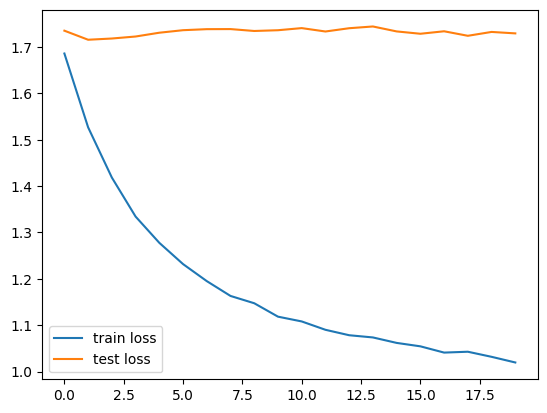

In [49]:
# plot losses
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

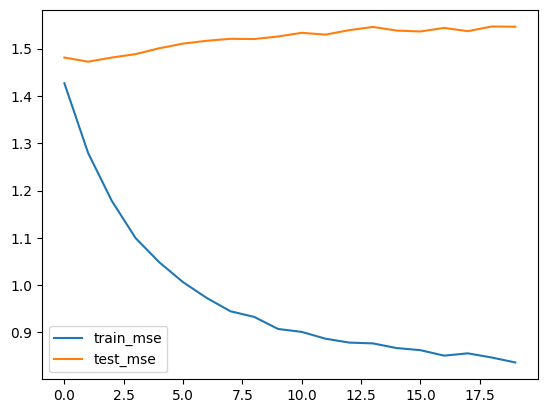

In [50]:
# plot mse
plt.plot(r.history['custom_loss'], label="train_mse")
plt.plot(r.history['val_custom_loss'], label="test_mse")
plt.legend()
plt.show()

- The autoencoder doesn’t explicitly learn user-item relationships like collaborative filtering does.
- It just tries to compress the rating matrix and reconstruct it, without knowing that rows are users and columns are items.
- This means the semantic meaning of users & items is lost—it treats the matrix just like any image pixel matrix.

🚨 Issue with Using Autoencoders for Recommendations:
- Unlike images, where pixels next to each other have spatial meaning, the order of users and items in the rating matrix is arbitrary.

- The autoencoder might learn some latent patterns in the rating distribution.
- But it won’t understand user preferences or item similarities explicitly.
- This is why autoencoders can work well for image regeneration but not necessarily for recommendations.

### Step 1: Input Batch (Generator)
- generator(A, M) yields batches of (noisy_A, A), where:
$$ noisy_A: The input rating matrix (with some normalization applied). $$
$$ A: The original rating matrix (used as ground truth for reconstruction). $$

### Step 2: Encoding (Compression)
- The autoencoder reduces the dimensionality of noisy_A, creating a latent representation (hidden compressed features).

### Step 3: Decoding (Reconstruction)
- The model reconstructs a rating matrix (same shape as A), trying to match the original ratings.